As an example of coupled ODEs consider harmonic oscillator in 2D
\begin{align}
x''(t) = -a x(t) + b (y(t) - x(t)) \\
y''(t) = -c y(t) + d (x(t) - y(t))
\end{align}
for $t \in [0,\infty)$ and now $a = 2$, $b = 1/4$, $c = 2$, $d = 2/3$. With initial conditions
\begin{align}
x(0) = 1 \\
y(0) = 0 \\
x'(0) = 0 \\
y'(0) = 0
\end{align}
analytic solutions is
\begin{align}
x(t) = \frac{1}{11} \left(8 \cos \left(\sqrt{2} t\right)+3 \cos
   \left(\frac{1}{2} \sqrt{\frac{35}{3}} t\right)\right) \\
y(t) = \frac{8}{11} \left(\cos \left(\sqrt{2} t\right)-\cos
   \left(\frac{1}{2} \sqrt{\frac{35}{3}} t\right)\right)
\end{align}

In [162]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.autograd as autograd
import solver2 as solver

def differential1(t, f):
    # x''(t) + 2x(t) - 1/4 (y(t) - x(t)) = 0
    t = t.requires_grad_(True)
    ft = f(t) # f(t) = (x(t), y(t))
    xt = ft[:,0].reshape(-1, 1)
    yt = ft[:,1].reshape(-1, 1)
    Dt_xt = autograd.grad(xt, t, grad_outputs=torch.ones_like(xt), create_graph=True)[0]
    D2t_xt = autograd.grad(Dt_xt, t, grad_outputs=torch.ones_like(Dt_xt), create_graph=True)[0]
    return D2t_xt + 2*xt - 0.25*(yt - xt)

def differential2(t, f):
    # y''(t) + 2y(t) - 2/3 (x(t) - y(t)) = 0
    t = t.requires_grad_(True)
    ft = f(t) # f(t) = (x(t), y(t))
    xt = ft[:,0].reshape(-1, 1)
    yt = ft[:,1].reshape(-1, 1)
    Dt_yt = autograd.grad(yt, t, grad_outputs=torch.ones_like(yt), create_graph=True)[0]
    D2t_yt = autograd.grad(Dt_yt, t, grad_outputs=torch.ones_like(Dt_yt), create_graph=True)[0]
    return D2t_yt + 2*yt - (2/3)*(xt - yt)

# Check the boundary conditions, in particular the dimensions

def boundary1(t0, f):
    # x(t0) - 1 = 0
    ft = f(t0)
    xt = ft[:,0].reshape(-1, 1)
    return xt - 1.0

def boundary2(t0, f):
    # y(t0) = 0
    ft = f(t0)
    yt = ft[:,1].reshape(-1, 1)
    return yt

def boundary3(t0, f):
    # x'(t0) = 0
    t0 = t0.requires_grad_(True)
    ft = f(t0)
    xt = ft[:,0].reshape(-1, 1)
    Dt_xt = autograd.grad(xt, t0, grad_outputs=torch.ones_like(xt), create_graph=True)[0]
    return Dt_xt

def boundary4(t0, f):
    # y'(t0) = 0
    t0 = t0.requires_grad_(True)
    ft = f(t0)
    yt = ft[:,1].reshape(-1, 1)
    Dt_yt = autograd.grad(yt, t0, grad_outputs=torch.ones_like(yt), create_graph=True)[0]
    return Dt_yt

t0 = torch.tensor([0.0]).reshape(-1,1) # Boundary (initial) condition value
bc_tuples = [(boundary1, t0), (boundary2, t0), (boundary3, t0), (boundary4, t0)]

differentials = [differential1, differential2]

num_points = 100
tmin = 0.0
tmax = 10.0
domain = torch.linspace(tmin, tmax, 100)[1:].reshape(-1, 1) # Do not include t0 in the domain

loss_fn = solver.LossFunction(differentials, bc_tuples)

Epoch 1/20000 Loss: 1.0265331268310547
Epoch 2/20000 Loss: 1.2232555150985718
Epoch 3/20000 Loss: 0.8010541200637817
Epoch 4/20000 Loss: 0.522883415222168
Epoch 5/20000 Loss: 0.6096219420433044
Epoch 6/20000 Loss: 0.5811042189598083
Epoch 7/20000 Loss: 0.47278326749801636
Epoch 8/20000 Loss: 0.4713672995567322
Epoch 9/20000 Loss: 0.51643967628479
Epoch 10/20000 Loss: 0.48723024129867554
Epoch 11/20000 Loss: 0.42159152030944824
Epoch 12/20000 Loss: 0.41701430082321167
Epoch 13/20000 Loss: 0.4546038508415222
Epoch 14/20000 Loss: 0.44238102436065674
Epoch 15/20000 Loss: 0.37038978934288025
Epoch 16/20000 Loss: 0.31707334518432617
Epoch 17/20000 Loss: 0.3312714397907257
Epoch 18/20000 Loss: 0.3656904995441437
Epoch 19/20000 Loss: 0.35421356558799744
Epoch 20/20000 Loss: 0.30649057030677795
Epoch 21/20000 Loss: 0.2811208665370941
Epoch 22/20000 Loss: 0.29991137981414795
Epoch 23/20000 Loss: 0.3238997459411621
Epoch 24/20000 Loss: 0.31545490026474
Epoch 25/20000 Loss: 0.2871641516685486
Epoc

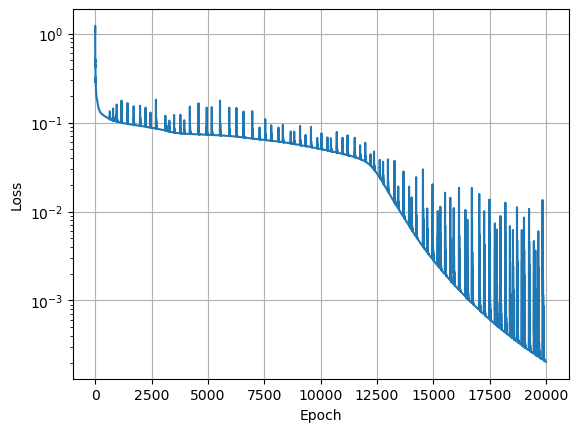

In [165]:
model = nn.Sequential(
    nn.Linear(1, 200),
    nn.Tanh(),
    nn.Linear(200, 200),
    nn.Tanh(),
    nn.Linear(200, 2)
)

epochs = 20000
lr = 0.0005
loss_data = solver.train(model, loss_fn, domain, epochs, lr, print_progress=True)

plt.plot(loss_data)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid()
plt.show()

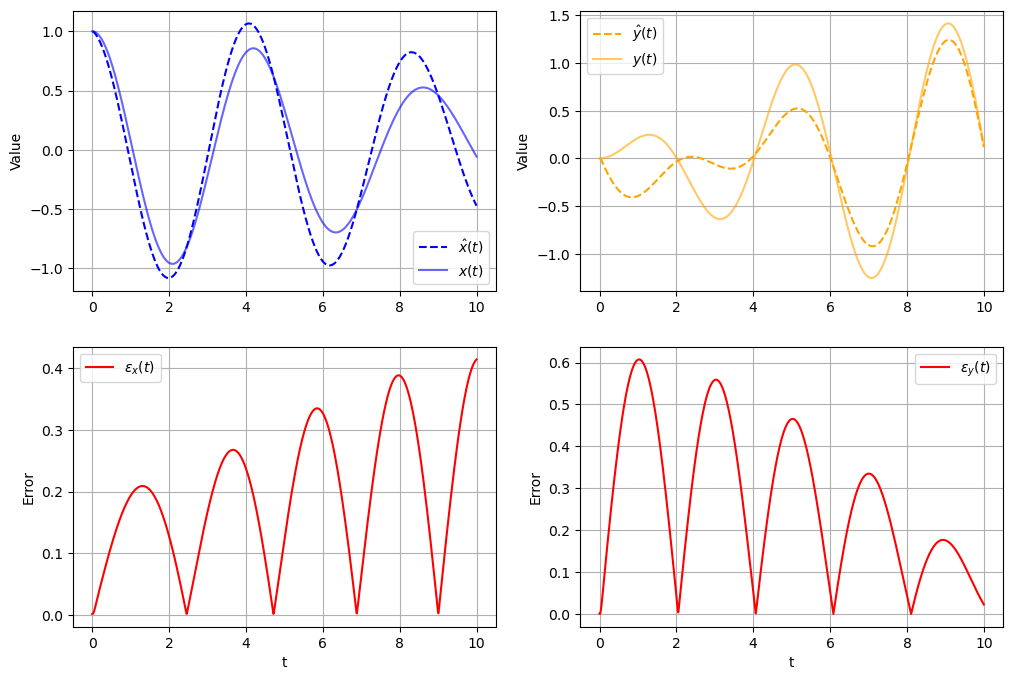

In [166]:
# Model analysis

def analytic_solution_x(t):
    return (1/11)*(8*np.cos(np.sqrt(2)*t) + 3*np.cos(0.5*np.sqrt(35/3)*t))

def analytic_solution_y(t):
    return (8/11)*(np.cos(np.sqrt(2)*t) - np.cos(0.5*np.sqrt(35/3)*t))


t_tensor = torch.linspace(tmin, tmax, 1000).reshape(-1, 1)
model_output = model(t_tensor)
x = model_output[:,0].detach().numpy()
y = model_output[:,1].detach().numpy()
t = t_tensor.detach().numpy()
x_analytic = analytic_solution_x(t).reshape(-1)
y_analytic = analytic_solution_y(t).reshape(-1)

x_error = np.abs(x - x_analytic)
y_error = np.abs(y - y_analytic)

fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0,0].plot(t, x, label=r'$\hat{x}(t)$', color='blue', linestyle='--')
ax[0,0].plot(t, x_analytic, label=r'$x(t)$', color='blue', alpha=0.6)
ax[0,0].set_ylabel('Value')
ax[0,0].legend()
ax[0,0].grid()
ax[1,0].plot(t, x_error, label=r'$\epsilon_x(t)$', color='red')
ax[1,0].set_xlabel('t')
ax[1,0].set_ylabel('Error')
ax[1,0].legend()
ax[1,0].grid()

ax[0,1].plot(t, y, label=r'$\hat{y}(t)$', color='orange', linestyle='--')
ax[0,1].plot(t, y_analytic, label=r'$y(t)$', color='orange', alpha=0.6)
ax[0,1].set_ylabel('Value')
ax[0,1].legend()
ax[0,1].grid()
ax[1,1].plot(t, y_error, label=r'$\epsilon_y(t)$', color='red')
ax[1,1].set_xlabel('t')
ax[1,1].set_ylabel('Error')
ax[1,1].legend()
ax[1,1].grid()

plt.show()


# plt.plot(t, x, label=r'$\hat{x}(t)$', color='blue', linestyle='--')
# plt.plot(t, y, label=r'$\hat{y}(t)$', color='orange', linestyle='--')
# plt.plot(t, x_analytic, label=r'$x(t)$', color='blue', alpha=0.6)
# plt.plot(t, y_analytic, label=r'$y(t)$', color='orange', alpha=0.6)
# plt.xlabel('t')
# plt.ylabel('Value')
# plt.legend()
# plt.grid()
# plt.show()

In [117]:
# Correct model
sqrt2_tensor = torch.tensor(np.sqrt(2))
sqrt35_3_tensor = torch.tensor(np.sqrt(35/3))

def correct_x_tensor(t):
    return (8/11)*torch.cos(sqrt2_tensor*t) + (3/11)*torch.cos(0.5*sqrt35_3_tensor*t)

def correct_y_tensor(t):
    return (8/11)*torch.cos(sqrt2_tensor*t) - (8/11)*torch.cos(0.5*sqrt35_3_tensor*t)


def correct_model(t):
    return torch.stack([correct_x_tensor(t), correct_y_tensor(t)], dim=1).reshape(-1, 2)

t_tensor = torch.linspace(tmin, tmax, 1000).reshape(-1, 1).requires_grad_(True)
t0 = torch.tensor([0.0]).requires_grad_(True)

differential1_test = differential1(t_tensor, correct_model)
differential2_test = differential2(t_tensor, correct_model)

# Something not right with the boundary conditions
bc1_test = boundary1(t0, correct_model)
bc2_test = boundary2(t0, correct_model)
bc3_test = boundary3(t0, correct_model)
bc4_test = boundary4(t0, correct_model)

max_abs_error_diff1 = np.abs(differential1_test.detach().numpy()).max()
max_abs_error_diff2 = np.abs(differential2_test.detach().numpy()).max()
print(max_abs_error_diff1)
print(max_abs_error_diff2)

max_abs_error_bc1 = np.abs(bc1_test.detach().numpy()).max()
max_abs_error_bc2 = np.abs(bc2_test.detach().numpy()).max()
max_abs_error_bc3 = np.abs(bc3_test.detach().numpy()).max()
max_abs_error_bc4 = np.abs(bc4_test.detach().numpy()).max()
print(max_abs_error_bc1)
print(max_abs_error_bc2)
print(max_abs_error_bc3)
print(max_abs_error_bc4)

3.7252903e-07
4.7683716e-07
0.0
0.0
0.0
0.0


Epoch 1/5000 Loss: 0.955150842666626
Epoch 2/5000 Loss: 0.8631091713905334
Epoch 3/5000 Loss: 0.7807809114456177
Epoch 4/5000 Loss: 0.7077610492706299
Epoch 5/5000 Loss: 0.6435067057609558
Epoch 6/5000 Loss: 0.5873409509658813
Epoch 7/5000 Loss: 0.5385010838508606
Epoch 8/5000 Loss: 0.4961985945701599
Epoch 9/5000 Loss: 0.45967262983322144
Epoch 10/5000 Loss: 0.4282341003417969
Epoch 11/5000 Loss: 0.40129247307777405
Epoch 12/5000 Loss: 0.37836208939552307
Epoch 13/5000 Loss: 0.3590461015701294
Epoch 14/5000 Loss: 0.3430035710334778
Epoch 15/5000 Loss: 0.3299095034599304
Epoch 16/5000 Loss: 0.3194218575954437
Epoch 17/5000 Loss: 0.31116580963134766
Epoch 18/5000 Loss: 0.30474215745925903
Epoch 19/5000 Loss: 0.29975584149360657
Epoch 20/5000 Loss: 0.29585397243499756
Epoch 21/5000 Loss: 0.2927573025226593
Epoch 22/5000 Loss: 0.29027441143989563
Epoch 23/5000 Loss: 0.2882936894893646
Epoch 24/5000 Loss: 0.28675806522369385
Epoch 25/5000 Loss: 0.28563255071640015
Epoch 26/5000 Loss: 0.284

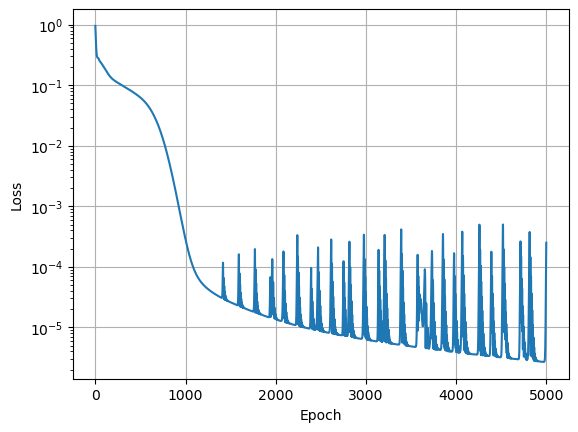

In [171]:
# Sine activation function helps convergence a lot!
# Check https://arxiv.org/abs/2109.09338

class Sine(nn.Module):
    def forward(self, x):
        return torch.sin(x)

model = nn.Sequential(
    nn.Linear(1, 100),
    Sine(),
    nn.Linear(100, 200),
    nn.Tanh(),
    nn.Linear(200, 100),
    nn.Tanh(),
    nn.Linear(100, 2)
)

epochs = 5000
lr = 0.0001
loss_data = solver.train(model, loss_fn, domain, epochs, lr, print_progress=True)

plt.plot(loss_data)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid()
plt.show()